In [31]:
# !pip install transformers
# !pip install keras_nlp
# !pip install datasets
# !pip install huggingface-hub huggingface_hub
# !pip install nltk
# !pip install rouge-score rouge
# !pip install evaluate
# nltk.download('punkt')

In [12]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [13]:
!git config --global user.email "oabass7@gmail.com"
!git config --global user.name "Jammal"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer 
from transformers.keras_callbacks import  KerasMetricCallback
import evaluate
import nltk
from nltk.corpus import stopwords

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

In [14]:
import transformers

print(transformers.__version__)

4.29.2


## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with 1 out of the 9 classification categories due to low compute unit.

In [3]:
df = load_dataset("big_patent", "d")

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [5]:
df["train"][0]

{'description': 'BACKGROUND OF THE INVENTION \n     This invention relates to a method and apparatus for forming fiber mixtures from a plurality of fiber types by sequentially taking, from different fiber lots such as fiber bales, partial quantities which are small with respect to the entire quantity of the mixture. \n     German Laid-Open Applications (Offenlegungsschriften) Nos. 1,685,596 (to which corresponds U.S. Pat. No. 3,577,599) and 2,063,415 disclose a method according to which a plurality of fiber bales containing the same kind of fiber are positioned next to a plurality of fiber bales of another type of fiber. A carriage is moved past the fiber bales and the bale opener mounted thereon takes from each fiber type a partial quantity so that the composition of the partial quantities obtained during each pass has the desired predetermined mixture ratio. At the same time, care is taken that, in case the required individual partial quantity of one fiber type is not reached during 

### Define Certain Variables

In [6]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 512  

# Batch-size for training our model
BATCH_SIZE = 16

## T5 Model

#### Data preprocessing

In [7]:
MODEL_CHECKPOINT = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [8]:
def preprocess_function(examples):
    inputs = [prefix + inp for inp in examples["description"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)
    targets = examples["abstract"]

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [9]:
tokenized_df = df.map(preprocess_function, batched=True)

Map:   0%|          | 0/10164 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

In [10]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 10164
})

### Fine-tuning the Model

In [11]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [15]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patent"

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model,return_tensors="np",pad_to_multiple_of=128)

In [17]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_df["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)

tf_generation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=generation_data_collator
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Compiling the Model

In [18]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Evaluate the Model

In [19]:
# rouge = evaluate.load("rouge")

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
#     result["gen_len"] = np.mean(prediction_lens)

#     return {k: round(v, 4) for k, v in result.items()}


# # compute the ROUGE score from the predictions
# metric_callback = KerasMetricCallback(
#     metric_fn=compute_metrics, 
#     eval_dataset=tf_validation_set,
#     predict_with_generate=True
#     )

# callbacks = [metric_callback]

In [25]:
metric = load_metric("rouge")

def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

In [22]:
# from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
# from tensorflow.keras.callbacks import TensorBoard

# tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./summarization_model_save",
#     tokenizer=tokenizer,
#     hub_model_id=push_to_hub_model_id,
# )

### Train the Model

In [27]:
metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback]

history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
635/635 [==============================] - 178s 281ms/step - loss: 2.4465 - val_loss: 2.2844 - rouge1: 20.2461 - rouge2: 10.6800 - rougeL: 17.3235 - rougeLsum: 18.3199 - gen_len: 19.0000
Epoch 2/3
635/635 [==============================] - 160s 252ms/step - loss: 2.4162 - val_loss: 2.2647 - rouge1: 20.2360 - rouge2: 10.7695 - rougeL: 17.3407 - rougeLsum: 18.2684 - gen_len: 19.0000
Epoch 3/3
635/635 [==============================] - 160s 251ms/step - loss: 2.3927 - val_loss: 2.2548 - rouge1: 20.3075 - rouge2: 10.8451 - rougeL: 17.3824 - rougeLsum: 18.3131 - gen_len: 19.0000


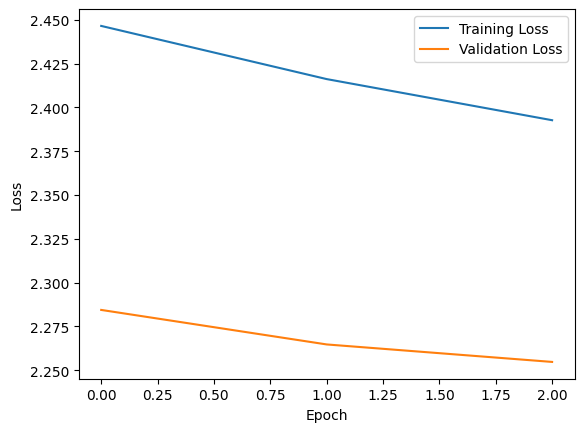

In [28]:
# Plot the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Save the model in SavedModel format
model.save("my_model", save_format="tf")

## MT5 Model

## BART Model

## PEGASUS Model

## GP2 Model